In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [11]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.34.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [6]:
image_pipe.scheduler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [7]:
image_pipe.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [ ]:
images = image_pipe(num_inference_steps=50, batch_size=5).images


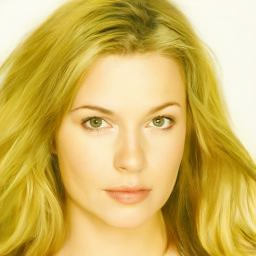

In [9]:
images[2]

In [10]:
# from diffusers import DDIMScheduler

# image_pipe.scheduler = DDIMScheduler.from_config(image_pipe.scheduler.config)

# images = image_pipe(
#     batch_size = 3,
#     num_inference_steps=50
# ).images

# images[0]

In [11]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [12]:
scheduler.timesteps


tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

In [13]:
image_pipe.unet.config.sample_size

256

0it [00:00, ?it/s]

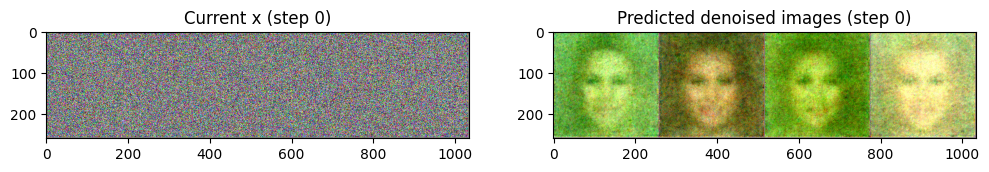

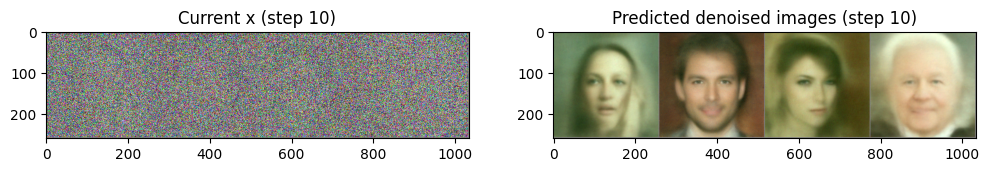

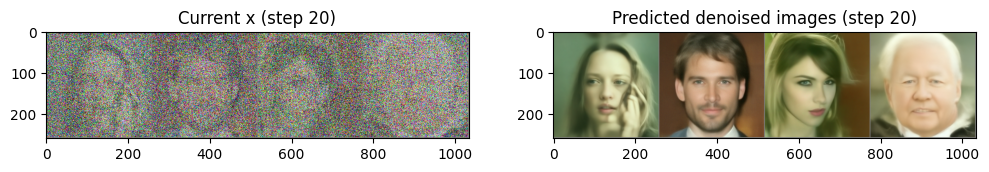

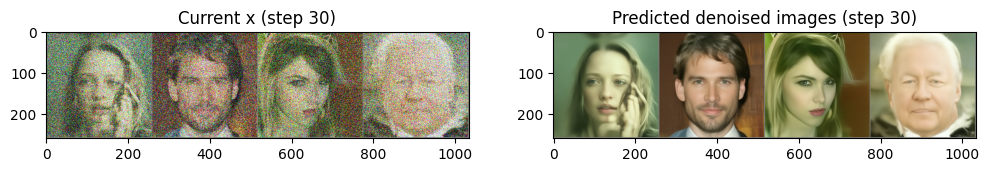

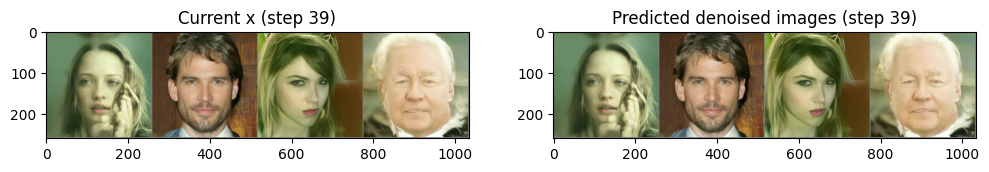

In [14]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images | image_pipe.unet.config.sample_size -> 256

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t) #nothing change here for now

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"] # predicting epsilon

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x) #calculate two things

    # Update x
    x = scheduler_output.prev_sample #calculates x_(T - 1)

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # directly jumping from x_T to x_0
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [15]:
??scheduler.step


Signature:
scheduler.step(
    model_output: torch.Tensor,
    timestep: int,
    sample: torch.Tensor,
    eta: float = 0.0,
    use_clipped_model_output: bool = False,
    generator=None,
    variance_noise: Optional[torch.Tensor] = None,
    return_dict: bool = True,
) -> Union[diffusers.schedulers.scheduling_ddim.DDIMSchedulerOutput, Tuple]
Source:   
    def step(
        self,
        model_output: torch.Tensor,
        timestep: int,
        sample: torch.Tensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        variance_noise: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.Tensor`):
                The direct o

  0%|          | 0/40 [00:00<?, ?it/s]

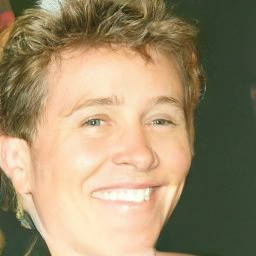

In [16]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [17]:
#load dataet
from datasets import load_dataset

ds = load_dataset("huggan/smithsonian_butterflies_subset", split= 'train')



README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [18]:
#prepocessing dataset
from torchvision.transforms import v2
img_size = 256
batch_size = 4

preprocess = v2.Compose([
    v2.Resize(size=(img_size, img_size) , antialias=True ),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize([0.5], [0.5])

])


def transform(ex):
    image = [preprocess(img.convert('RGB')) for img in ex['image']]
    return {"image" : image}


ds.set_transform(transform)

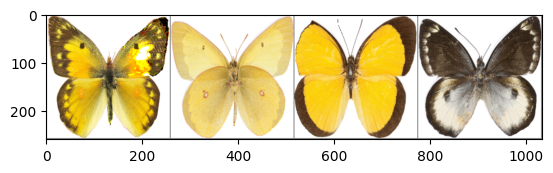

In [41]:
train_dataloader = torch.utils.data.DataLoader(
    dataset = ds,
    batch_size = batch_size,
    shuffle = True,
)

#printing batch

img_batch = next(iter(train_dataloader))['image']

grid = torchvision.utils.make_grid(img_batch)

plt.imshow(grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5)
plt.show()

In [20]:
from tqdm.auto import tqdm

num_epoch = 2
lr = 1e-5

losses = []

grad_accumulation_steps = 2 # see explanation below |  as img size was 256(large) that's why we used small batch size

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr = lr)

for epoch in range(num_epoch):
    for step , batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        clean_image = batch['image'].to(device)

        noise = torch.randn_like(clean_image).to(clean_image.device)

        timesteps = torch.randint(0 , image_pipe.scheduler.config.num_train_timesteps, (clean_image.shape[0],), device = clean_image.device).long()

        noisy_image = image_pipe.scheduler.add_noise(clean_image , noise, timesteps)

        noise_pred = image_pipe.unet(noisy_image, timesteps, return_dict=False )[0]

        loss = F.mse_loss(noise_pred , noise)

        losses.append(loss.item())

        loss.backward()

        if(step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")




  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0 average loss: 0.013437058361188975


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.01238471224642126


### What is grad_accumulation_steps?


`grad_accumulation_steps = 2` implements gradient accumulation, a common technique in deep learning training when you want a larger effective batch size but are limited by GPU memory (VRAM).
* Your actual batch size (`bs`) comes from the dataloader (e.g., whatever size fits in memory for one forward/backward pass).

* With gradient accumulation:
    * You compute gradients for each mini-batch normally.
    * But you only update the model parameters every N mini-batches, where `N = grad_accumulation_steps`.
    * In between, gradients from multiple mini-batches accumulate (add up) in the `.grad` fields of the parameters.


Effective batch size = `actual batch size` x `grad_accumulation_steps`

---

In code:

* For every 2 mini-batches:
    * Gradients from batch 1 are computed and stored.
    * Gradients from batch 2 are computed and added to the previous ones.
    * Then optimizer.step() updates parameters using the summed gradients (equivalent to a batch twice as large).
    * optimizer.zero_grad() clears them for the next accumulation cycle.

###---

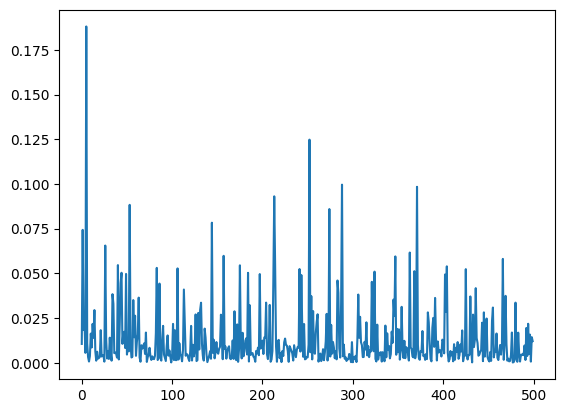

In [21]:
plt.plot(losses)

  0%|          | 0/50 [00:00<?, ?it/s]

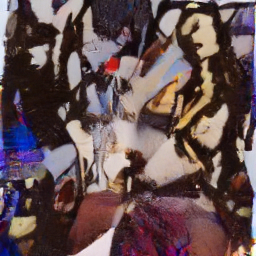

In [22]:
DDPMPipeline(unet=image_pipe.unet, scheduler=image_pipe.scheduler)(num_inference_steps=50).images[0]


In [24]:
image_pipe.save_pretrained('my-fine-tuned-on-celbebhq-with-butterfly')


In [26]:
from huggingface_hub import HfApi, ModelCard, get_full_repo_name, create_repo

model_name = 'ddpm-celebahq-finetuned-butterflies-2epochs'
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs'

In [27]:
create_repo(hub_model_id)

api = HfApi()



In [28]:
api.upload_folder(
    folder_path = 'my-fine-tuned-on-celbebhq-with-butterfly/scheduler',
    path_in_repo = '',
    repo_id = hub_model_id
)

api.upload_folder(
    folder_path = 'my-fine-tuned-on-celbebhq-with-butterfly/unet',
    path_in_repo = '',
    repo_id = hub_model_id
)

api.upload_file(
    path_or_fileobj = 'my-fine-tuned-on-celbebhq-with-butterfly/model_index.json',
    path_in_repo = 'model_index.json',
    repo_id = hub_model_id
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs/commit/bceac0d5b31915092dec36db3a7e46af13a0085a', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='bceac0d5b31915092dec36db3a7e46af13a0085a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs', endpoint='https://huggingface.co', repo_type='model', repo_id='abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs'), pr_revision=None, pr_num=None)

In [34]:

description = "In this model, we load a pretained model : celebhq-256 and fine tuned on butterfly images with only 2 epochs." 

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
"""

card = ModelCard(content) 
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs/commit/2e20493dd88fcc163c87ca77196e7d2aed6b42a1', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='2e20493dd88fcc163c87ca77196e7d2aed6b42a1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs', endpoint='https://huggingface.co', repo_type='model', repo_id='abcd2019/ddpm-celebahq-finetuned-butterflies-2epochs'), pr_revision=None, pr_num=None)

### For the rest of this notebook we'll use a [model](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms) I fine-tuned from [this model trained on LSUN bedrooms](https://huggingface.co/google/ddpm-bedroom-256) approximately one epoch on the [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart). If you'd prefer, you can skip this cell and use the faces/butterflies pipeline we fine-tuned in the previous section or load one from the Hub instead:


2025-12-25 15:53:03.536960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766677983.710551      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766677983.766540      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766677984.186408      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766677984.186449      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766677984.186451      55 computation_placer.cc:177] computation placer alr

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-bedroom-256/snapshots/d6ccd889ac8a4c072ae35e63fed664718cdaa060: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-bedroom-256/snapshots/d6ccd889ac8a4c072ae35e63fed664718cdaa060.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

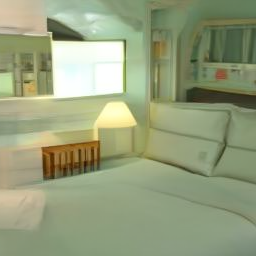

In [1]:
# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

model_id = "google/ddpm-bedroom-256"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference

# run pipeline in inference (sample random noise and denoise)
image = ddpm(num_inference_steps = 50).images[0]


# save image
image

In [2]:
ddpm.scheduler.num_train_timesteps , len(ddpm.scheduler.timesteps )

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


(1000, 50)

In [5]:
len(ddpm.scheduler.alphas_cumprod)

1000

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

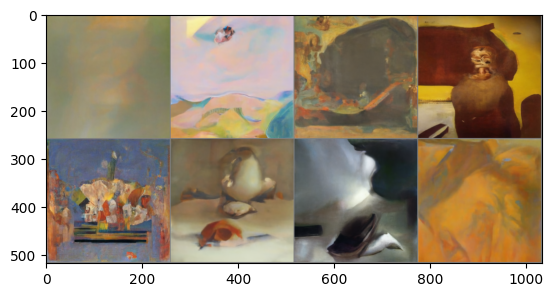

In [12]:

# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [17]:
len(scheduler.alphas_cumprod), scheduler.alphas_cumprod[:10].sqrt(), len(scheduler.timesteps),scheduler.alphas_cumprod[:10]

(1000,
 tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996, 0.9994, 0.9993, 0.9992,
         0.9991]),
 40,
 tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986, 0.9984,
         0.9981]))

In [50]:
 target_color=(0.1, 0.9, 0.5)

target = torch.tensor(target_color).to(device) * 2 - 1 

target

tensor([-0.8000,  0.8000,  0.0000], device='cuda:0')

In [51]:
target = target[None, :, None, None]
target, target.shape

(tensor([[[[-0.8000]],
 
          [[ 0.8000]],
 
          [[ 0.0000]]]], device='cuda:0'),
 torch.Size([1, 3, 1, 1]))

In [53]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = torch.tensor(target_color).to(images.device) * 2 - 1  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

  0%|          | 0/40 [00:00<?, ?it/s]

0 loss: 14.323394775390625
10 loss: 10.248405456542969
20 loss: 10.023300170898438
30 loss: 10.103516578674316


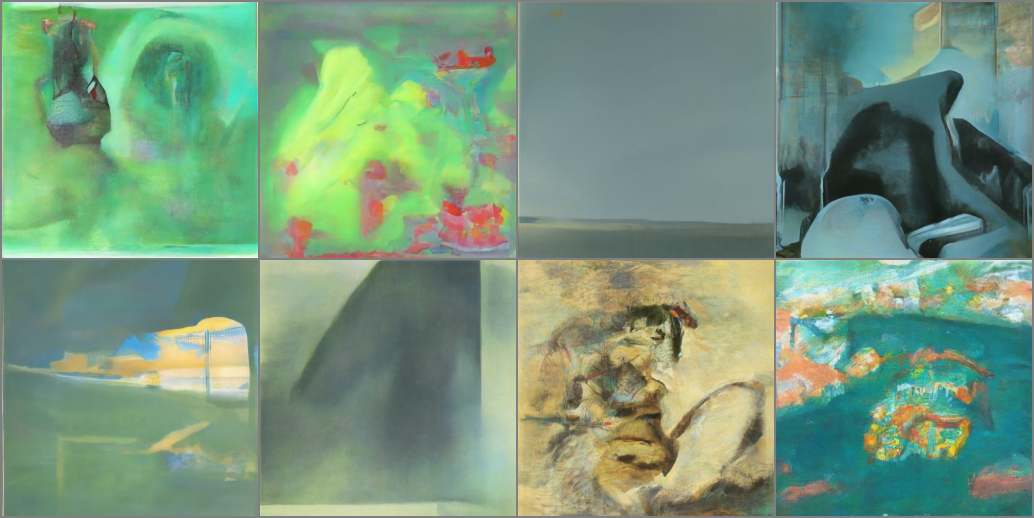

In [63]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 20  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [32]:
# To download the fine-tuning script:
!wget https://github.com/huggingface/diffusion-models-class/raw/main/unit2/finetune_model.py

--2025-12-24 14:53:35--  https://github.com/huggingface/diffusion-models-class/raw/main/unit2/finetune_model.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/huggingface/diffusion-models-class/main/unit2/finetune_model.py [following]
--2025-12-24 14:53:46--  https://raw.githubusercontent.com/huggingface/diffusion-models-class/main/unit2/finetune_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4491 (4.4K) [text/plain]
Saving to: ‘finetune_model.py.1’

finetune_model.py.1 100%[===================>]   4.39K  --.-KB/s    in 0s      

2025-12-24 14:53:46 (55.8 MB/s) - ‘finetune_model.py.1’